<h4 style="
    font-family: 'Rockwell', cursive; 
    font-weight: bold; 
    letter-spacing: 1px; 
    color: #ffcc80; /* Ana başlıkla aynı Amber rengi */
    font-size: 135%; 
    text-align: left; 
    padding: 0px; 
    margin-top: 20px; 
    margin-bottom: 10px; 
    border: none; /* Kenarlık veya çizgi yok */
">
    🔹<strong style="vertical-align: middle;">&nbsp;Import Libraries&nbsp;</strong>🔹
</h4>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.inspection import permutation_importance
from category_encoders import CatBoostEncoder

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import tensorflow as tf

from tqdm.auto import tqdm
import optuna

from sklearn import set_config
set_config(display='diagram')

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set_palette('pastel')

!wget https://raw.githubusercontent.com/h4pZ/rose-pine-matplotlib/main/themes/rose-pine-dawn.mplstyle -P /tmp
plt.style.use("/tmp/rose-pine-dawn.mplstyle")

2025-05-16 19:45:29.249008: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747424729.432533      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747424729.486604      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


--2025-05-16 19:45:41--  https://raw.githubusercontent.com/h4pZ/rose-pine-matplotlib/main/themes/rose-pine-dawn.mplstyle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40905 (40K) [text/plain]
Saving to: ‘/tmp/rose-pine-dawn.mplstyle’

rose-pine-dawn.mpls 100%[===================>]  39.95K  --.-KB/s    in 0.02s   

2025-05-16 19:45:42 (2.17 MB/s) - ‘/tmp/rose-pine-dawn.mplstyle’ saved [40905/40905]



<h4 style="
    font-family: 'Rockwell', cursive; 
    font-weight: bold; 
    letter-spacing: 1px; 
    color: #ffcc80; /* Ana başlıkla aynı Amber rengi */
    font-size: 135%; 
    text-align: left; 
    padding: 0px; 
    margin-top: 20px; 
    margin-bottom: 10px; 
    border: none; /* Kenarlık veya çizgi yok */
">
    🔹<strong style="vertical-align: middle;">&nbsp;Load Data & First Look&nbsp;</strong>🔹
</h4>

In [2]:
train = pd.read_csv(r'/kaggle/input/playground-series-s4e1/train.csv', index_col = 'id').astype({'IsActiveMember' : np.uint8, 'HasCrCard' : np.uint8})
test = pd.read_csv(r'/kaggle/input/playground-series-s4e1/test.csv', index_col = 'id').astype({'IsActiveMember' : np.uint8, 'HasCrCard' : np.uint8})
orig_train = pd.read_csv(r'/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv', index_col = 'RowNumber')

In [3]:
train.head(10)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.000,3,0.000,2,1,0,181449.970,0
1,15749177,Okwudiliolisa,627,France,Male,33.000,1,0.000,2,1,1,49503.500,0
2,15694510,Hsueh,678,France,Male,40.000,10,0.000,2,1,0,184866.690,0
3,15741417,Kao,581,France,Male,34.000,2,148882.540,1,1,1,84560.880,0
4,15766172,Chiemenam,716,Spain,Male,33.000,5,0.000,2,1,1,15068.830,0
5,15771669,Genovese,588,Germany,Male,36.000,4,131778.580,1,1,0,136024.310,1
6,15692819,Ch'ang,593,France,Female,30.000,8,144772.690,1,1,0,29792.110,0
7,15669611,Chukwuebuka,678,Spain,Male,37.000,1,138476.410,1,1,0,106851.600,0
8,15691707,Manna,676,France,Male,43.000,4,0.000,2,1,0,142917.130,0


In [4]:
test.head(10)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
id,,,,,,,,,,,,
165034,15773898,Lucchese,586,France,Female,23.000,2,0.000,2,0,1,160976.750
165035,15782418,Nott,683,France,Female,46.000,2,0.000,1,1,0,72549.270
165036,15807120,K?,656,France,Female,34.000,7,0.000,2,1,0,138882.090
165037,15808905,O'Donnell,681,France,Male,36.000,8,0.000,1,1,0,113931.570
165038,15607314,Higgins,752,Germany,Male,38.000,10,121263.620,1,1,0,139431.000
165039,15672704,Pearson,593,France,Female,22.000,9,0.000,2,0,0,51907.720
165040,15647838,Onyemere,682,Spain,Male,45.000,4,0.000,2,1,1,157878.670
165041,15775307,Hargreaves,539,Spain,Female,47.000,8,0.000,2,1,1,126784.290
165042,15653937,Hsueh,845,France,Female,47.000,3,111096.910,1,1,0,94978.100


In [5]:
orig_train.head(10)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.000,1,1,1,101348.880,1
2,15647311,Hill,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0
3,15619304,Onio,502,France,Female,42,8,159660.800,3,1,0,113931.570,1
4,15701354,Boni,699,France,Female,39,1,0.000,2,0,0,93826.630,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,0
6,15574012,Chu,645,Spain,Male,44,8,113755.780,2,1,0,149756.710,1
7,15592531,Bartlett,822,France,Male,50,7,0.000,2,1,1,10062.800,0
8,15656148,Obinna,376,Germany,Female,29,4,115046.740,4,1,0,119346.880,1
9,15792365,He,501,France,Male,44,4,142051.070,2,0,1,74940.500,0


In [6]:
def summary_statistics(df, df_name="DataFrame", decimal_places=2):
    """
    Returns a DataFrame containing summary descriptive statistics for each column
    in the given DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame for which statistics will be calculated.
    df_name (str): The name of the DataFrame to be used in the summary table's title.
    decimal_places (int): The number of decimal places for percentage values.

    Returns:
    pd.DataFrame: A summary DataFrame with column names as the index and statistics
                  in the columns.
    """

    stats_dict = {
        'Data Type': df.dtypes,
        'Total Records (Non-Null)': df.count(),
        'Number of Unique Values': df.nunique(),
        'Number of Null Values': df.isnull().sum(),
    }
    
    try:
        # For non-numeric columns, alphabetical min/max is taken
        stats_dict['Min Value'] = df.min(numeric_only=False)
    except TypeError:
        print(f"WARNING ({df_name}): Error due to mixed data types while calculating 'Min Value'. This column is being skipped.")
        stats_dict['Min Value'] = '-' # Put a dash in case of error
        
    try:
        stats_dict['Max Value'] = df.max(numeric_only=False)
    except TypeError:
        print(f"WARNING ({df_name}): Error due to mixed data types while calculating 'Max Value'. This column is being skipped.")
        stats_dict['Max Value'] = '-' # Put a dash in case of error

    summary_df = pd.DataFrame(stats_dict)

    summary_df['Unique Values (%)'] = (summary_df['Number of Unique Values'] / len(df) * 100).round(decimal_places)
    summary_df['Null Values (%)'] = (summary_df['Number of Null Values'] / len(df) * 100).round(decimal_places)
    
    column_order = [
        'Data Type', 'Total Records (Non-Null)',
        'Number of Unique Values', 'Unique Values (%)',
        'Number of Null Values', 'Null Values (%)',
        'Min Value', 'Max Value'
    ]
    current_column_order = [s for s in column_order if s in summary_df.columns]
    summary_df = summary_df[current_column_order]

    return summary_df


dataframes_to_analyze = {}

try:
    if 'train' in locals() or 'train' in globals():
        dataframes_to_analyze["Competition Training Data Set (train)"] = train
    else:
        print("WARNING: 'train' DataFrame is not defined, summary cannot be generated.")
        
    if 'test' in locals() or 'test' in globals():
        dataframes_to_analyze["Competition Test Data Set (test)"] = test
    else:
        print("WARNING: 'test' DataFrame is not defined, summary cannot be generated.")
        
    if 'orig_train' in locals() or 'orig_train' in globals():
        dataframes_to_analyze["Original Churn Data Set (orig_train)"] = orig_train
    else:
        print("WARNING: 'orig_train' DataFrame is not defined, summary cannot be generated.")

except NameError as e:
    print(f"ERROR: One or more of the required DataFrames are not defined: {e}")
    print("Please ensure that the DataFrames are loaded.")


summary_tables = {}

if dataframes_to_analyze: # If there is at least one DataFrame to analyze
    for df_name, df_object in dataframes_to_analyze.items():
        print(f"\n\n{'='*70}") # Separator for each DataFrame summary
        # Call the function
        summary_df = summary_statistics(df_object, df_name=df_name) # df_adi should be df_name to match func definition
        summary_tables[df_name] = summary_df # Store the result
        
        # To display the table nicely in a Jupyter Notebook or similar environment:
        from IPython.display import display
        print(f"\nSummary Table for '{df_name}':")
        display(summary_df) # or you can use print(summary_df)
        print(f"{'='*70}\n")
else:
    print("\nNo DataFrames found to summarize. Please load the DataFrames and check their names.")




Summary Table for 'Competition Training Data Set (train)':


,Data Type,Total Records (Non-Null),Number of Unique Values,Unique Values (%),Number of Null Values,Null Values (%),Min Value,Max Value
CustomerId,int64,165034,23221,14.070,0,0.000,15565701,15815690
Surname,object,165034,2797,1.690,0,0.000,Abazu,Zuyeva
CreditScore,int64,165034,457,0.280,0,0.000,350,850
Geography,object,165034,3,0.000,0,0.000,France,Spain
Gender,object,165034,2,0.000,0,0.000,Female,Male
Age,float64,165034,71,0.040,0,0.000,18.000,92.000
Tenure,int64,165034,11,0.010,0,0.000,0,10
Balance,float64,165034,30075,18.220,0,0.000,0.000,250898.090
NumOfProducts,int64,165034,4,0.000,0,0.000,1,4
HasCrCard,uint8,165034,2,0.000,0,0.000,0,1






Summary Table for 'Competition Test Data Set (test)':


,Data Type,Total Records (Non-Null),Number of Unique Values,Unique Values (%),Number of Null Values,Null Values (%),Min Value,Max Value
CustomerId,int64,110023,19698,17.900,0,0.000,15565701,15815690
Surname,object,110023,2708,2.460,0,0.000,Abazu,Zuyeva
CreditScore,int64,110023,454,0.410,0,0.000,350,850
Geography,object,110023,3,0.000,0,0.000,France,Spain
Gender,object,110023,2,0.000,0,0.000,Female,Male
Age,float64,110023,74,0.070,0,0.000,18.000,92.000
Tenure,int64,110023,11,0.010,0,0.000,0,10
Balance,float64,110023,22513,20.460,0,0.000,0.000,250898.090
NumOfProducts,int64,110023,4,0.000,0,0.000,1,4
HasCrCard,uint8,110023,2,0.000,0,0.000,0,1






Summary Table for 'Original Churn Data Set (orig_train)':


,Data Type,Total Records (Non-Null),Number of Unique Values,Unique Values (%),Number of Null Values,Null Values (%),Min Value,Max Value
CustomerId,int64,10000,10000,100.000,0,0.000,15565701,15815690
Surname,object,10000,2932,29.320,0,0.000,Abazu,Zuyeva
CreditScore,int64,10000,460,4.600,0,0.000,350,850
Geography,object,10000,3,0.030,0,0.000,France,Spain
Gender,object,10000,2,0.020,0,0.000,Female,Male
Age,int64,10000,70,0.700,0,0.000,18,92
Tenure,int64,10000,11,0.110,0,0.000,0,10
Balance,float64,10000,6382,63.820,0,0.000,0.000,250898.090
NumOfProducts,int64,10000,4,0.040,0,0.000,1,4
HasCrCard,int64,10000,2,0.020,0,0.000,0,1


In [7]:
numerical_features = list(test._get_numeric_data())
categorical_features = list(test.drop(numerical_features, axis = 1))

print("---Numerical Features---")
print(numerical_features)
print(f"\n{'='*70}\n")
print("---Categorical Features---")
print(categorical_features)

---Numerical Features---
['CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


---Categorical Features---
['Surname', 'Geography', 'Gender']


<h4 style="
    font-family: 'Rockwell', cursive; 
    font-weight: bold; 
    letter-spacing: 1px; 
    color: #ffcc80; /* Ana başlıkla aynı Amber rengi */
    font-size: 135%; 
    text-align: left; 
    padding: 0px; 
    margin-top: 20px; 
    margin-bottom: 10px; 
    border: none; /* Kenarlık veya çizgi yok */
">
    🔹<strong style="vertical-align: middle;">&nbsp;Preparing Data&nbsp;</strong>🔹
</h4>

In [8]:
X = pd.concat([orig_train, train]).reset_index(drop = True)
y = X.pop('Exited')

orig_comp_combo = train.merge(orig_train, on = list(test), how = 'left')
orig_comp_combo.index = train.index

orig_test_combo = test.merge(orig_train, on = list(test), how = 'left')
orig_test_combo.index = test.index

seed = 42
splits = 30
skf = StratifiedKFold(n_splits = splits, random_state = seed, shuffle = True)
tf.keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism()

In [9]:
X.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15634602,Hargrave,619,France,Female,42.000,2,0.000,1,1,1,101348.880
1,15647311,Hill,608,Spain,Female,41.000,1,83807.860,1,0,1,112542.580
2,15619304,Onio,502,France,Female,42.000,8,159660.800,3,1,0,113931.570
3,15701354,Boni,699,France,Female,39.000,1,0.000,2,0,0,93826.630
4,15737888,Mitchell,850,Spain,Female,43.000,2,125510.820,1,1,1,79084.100


<h4 style="
    font-family: 'Rockwell', cursive; 
    font-weight: bold; 
    letter-spacing: 1px; 
    color: #ffcc80; /* Ana başlıkla aynı Amber rengi */
    font-size: 135%; 
    text-align: left; 
    padding: 0px; 
    margin-top: 20px; 
    margin-bottom: 10px; 
    border: none; /* Kenarlık veya çizgi yok */
">
    🔹<strong style="vertical-align: middle;">&nbsp;Visualization & Analysis&nbsp;</strong>🔹
</h4>

In [10]:
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

In [11]:
true_numerical_cols = [col for col in numerical_cols if col not in ['CustomerId','HasCrCard', 'IsActiveMember']]
print("--- True Numerical Columns (for Analysis) ---")
print(true_numerical_cols)

--- True Numerical Columns (for Analysis) ---
['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']


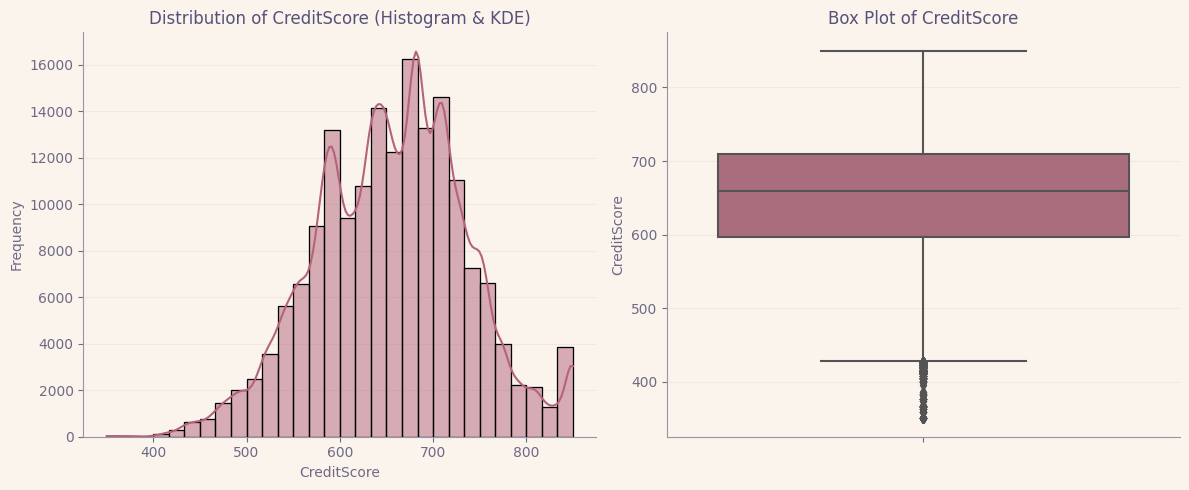

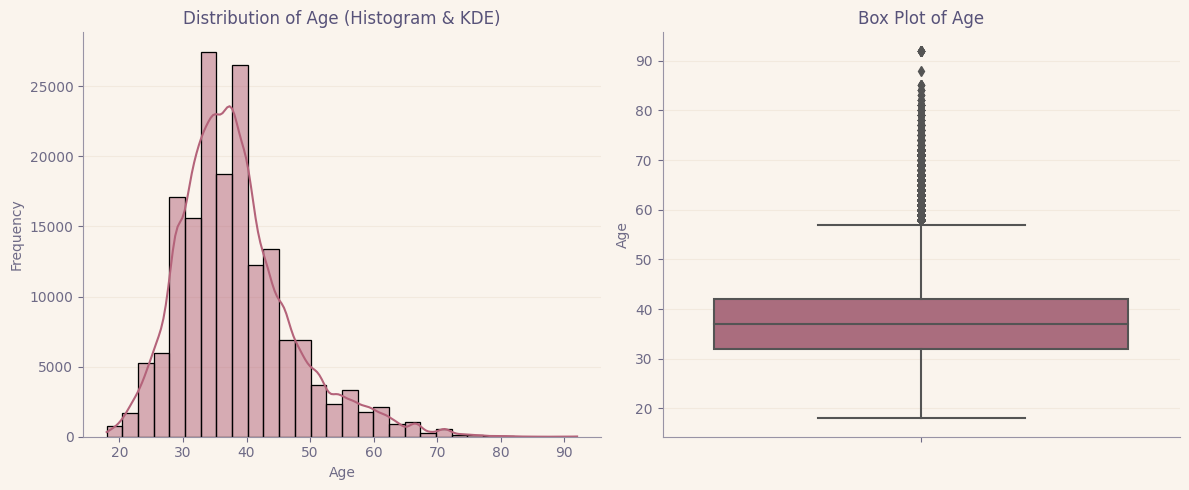

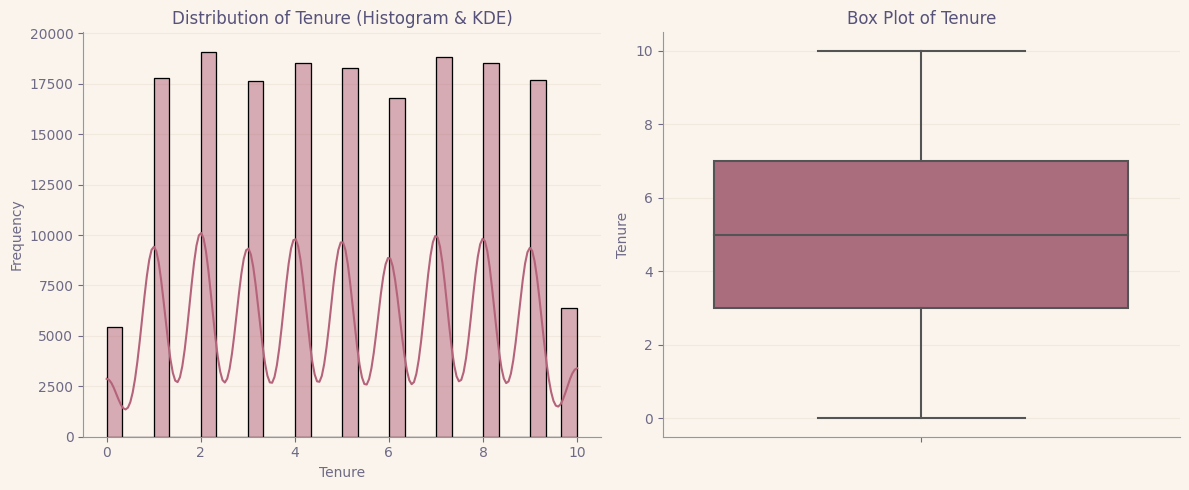

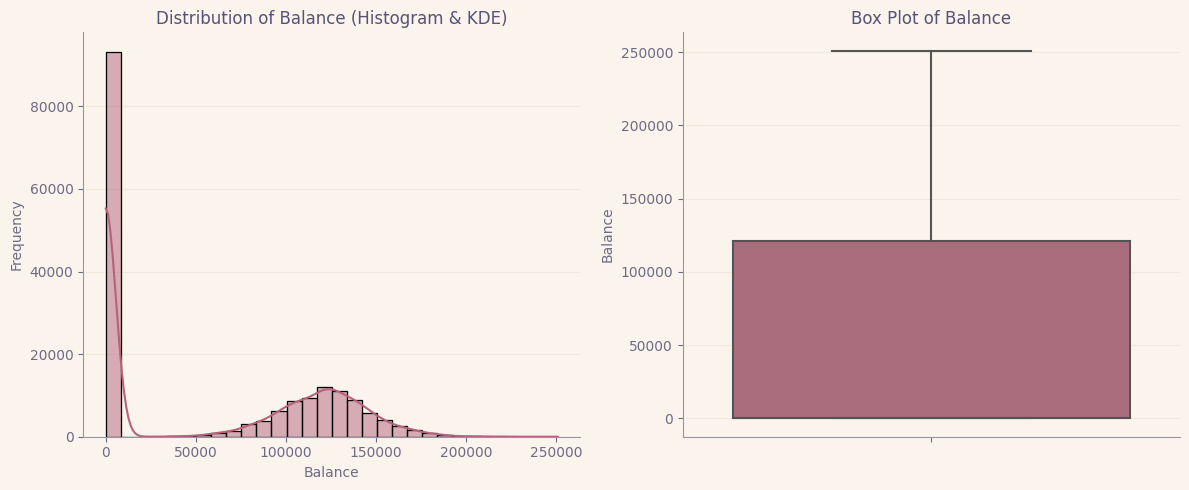

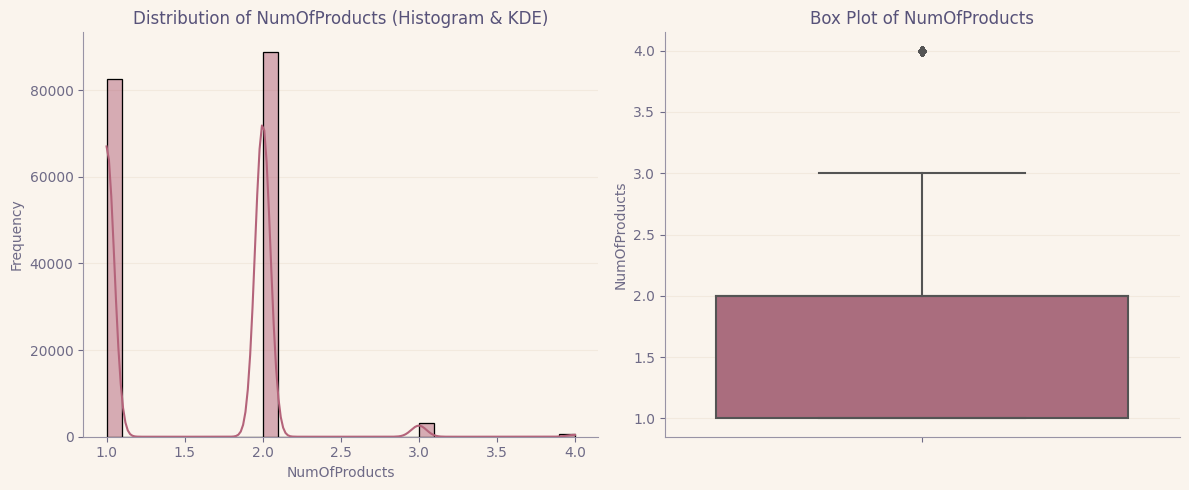

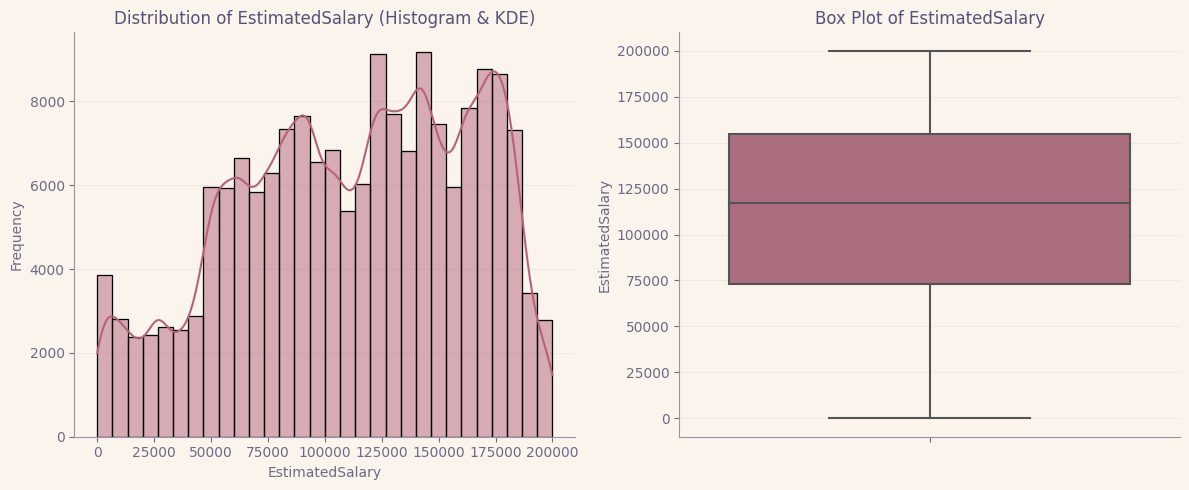

In [12]:
for col in true_numerical_cols:
    plt.figure(figsize=(12, 5))

    # Histogram and KDE
    plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st plot
    sns.histplot(X[col], kde=True, bins=30)
    plt.title(f'Distribution of {col} (Histogram & KDE)')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Box Plot
    plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot
    sns.boxplot(y=X[col])
    plt.title(f'Box Plot of {col}')
    plt.ylabel(col)

    plt.tight_layout() # Adjusts spacing between plots
    plt.show()

In [13]:
print("\n--- Basic Statistics of Numerical Variables ---")
X[true_numerical_cols].describe([0.1,0.25,0.50,0.75,0.90,0.95,0.99]).T


--- Basic Statistics of Numerical Variables ---


,count,mean,std,min,10%,25%,50%,75%,90%,95%,99%,max
CreditScore,175034.000,656.116,81.151,350.000,551.000,597.000,659.000,710.000,755.000,790.000,850.000,850.000
Age,175034.000,38.171,8.970,18.000,28.000,32.000,37.000,42.000,50.000,56.000,66.000,92.000
Tenure,175034.000,5.020,2.811,0.000,1.000,3.000,5.000,7.000,9.000,9.000,10.000,10.000
Balance,175034.000,56678.299,62982.566,0.000,0.000,0.000,0.000,120729.298,140691.070,152099.307,174060.460,250898.090
NumOfProducts,175034.000,1.553,0.549,1.000,1.000,1.000,2.000,2.000,2.000,2.000,3.000,4.000
EstimatedSalary,175034.000,111861.557,50815.383,11.580,42085.580,73192.370,116969.730,154767.340,176883.420,183570.620,196356.170,199992.480


--- Analysis of Categorical Variables ---

--- Analysis of Geography ---
Value Counts:
Geography
France     99229
Spain      38690
Germany    37115
Name: count, dtype: int64

Percentage Distribution:
Geography
France    56.691
Spain     22.104
Germany   21.204
Name: proportion, dtype: float64
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

--- Analysis of Gender ---
Value Counts:
Gender
Male      98607
Female    76427
Name: count, dtype: int64

Percentage Distribution:
Gender
Male     56.336
Female   43.664
Name: proportion, dtype: float64
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

--- Analysis of HasCrCard ---
Value Counts:
HasCrCard
1    131483
0     43551
Name: count, dtype

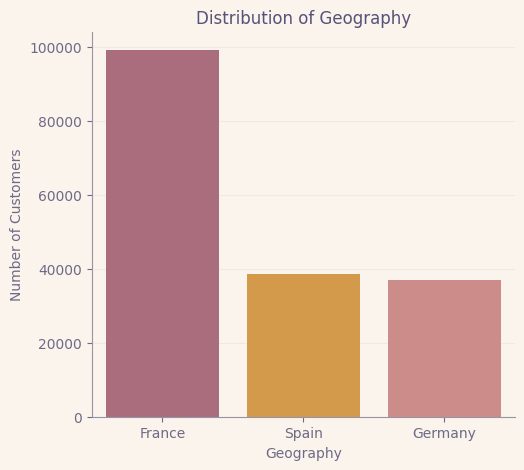

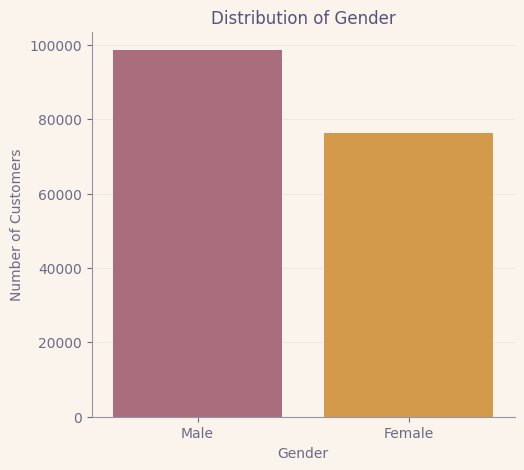

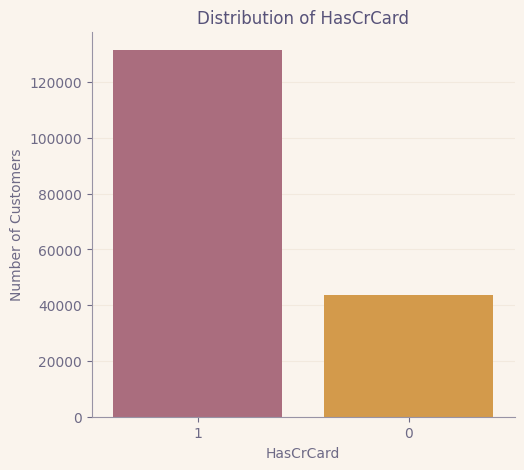

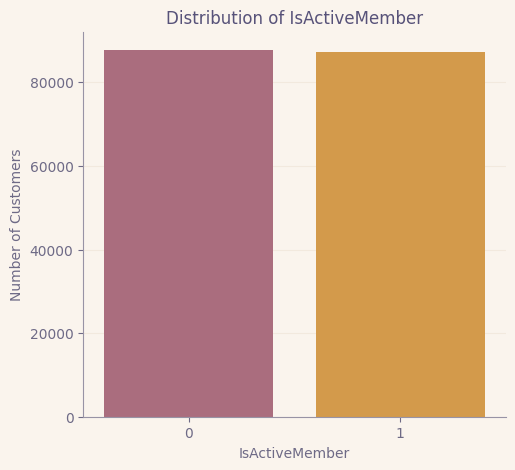

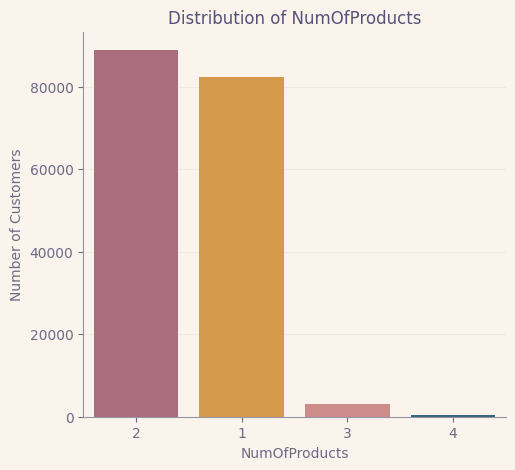

In [14]:
categorical_to_analyze = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'NumOfProducts']

print("--- Analysis of Categorical Variables ---")

for col in categorical_to_analyze:
    print(f"\n--- Analysis of {col} ---")
    print("Value Counts:")
    print(X[col].value_counts())
    print("\nPercentage Distribution:")
    print(X[col].value_counts(normalize=True) * 100)

    print("-" * 100 + "\n" + "-" * 100)

    # Visualization: Overall distribution of categories
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.countplot(x=col, data=X, order=X[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Number of Customers')

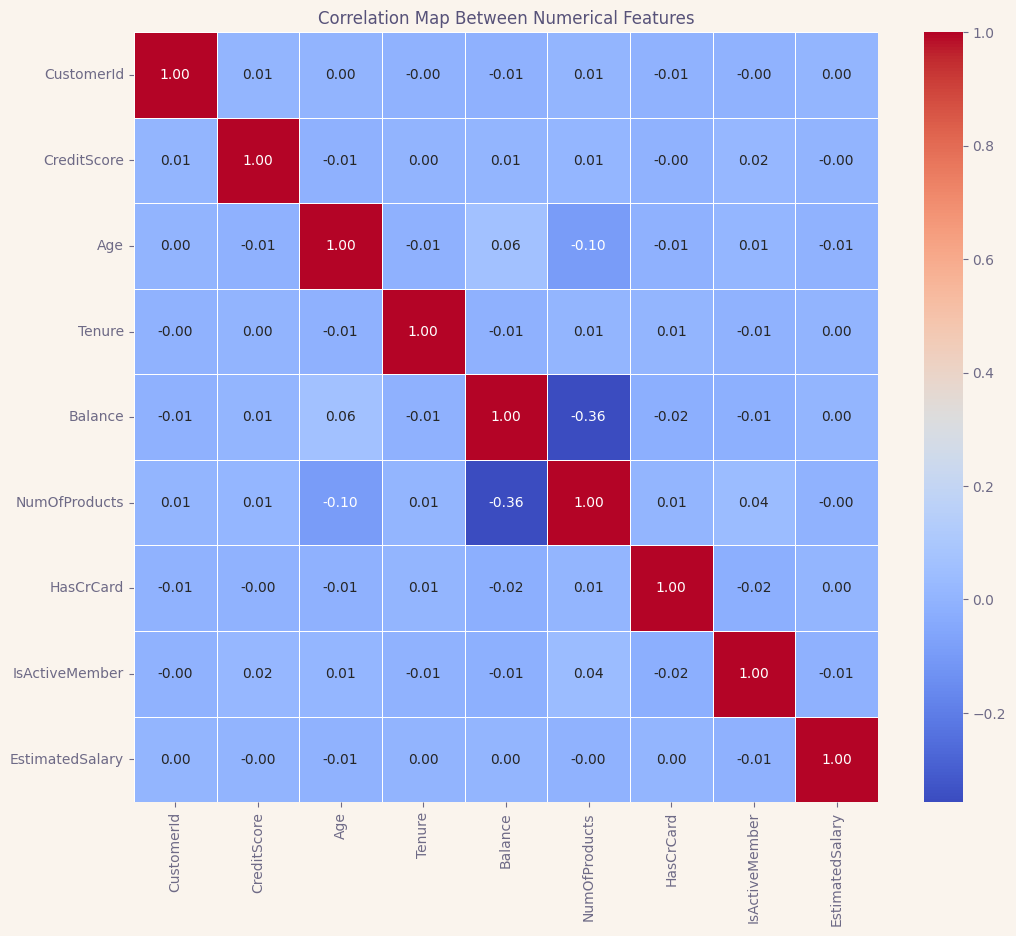

In [15]:
numerical_cols_for_corr = X.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(12, 10))
correlation_matrix = X[numerical_cols_for_corr].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Map Between Numerical Features')
plt.show()

<h4 style="
    font-family: 'Rockwell', cursive; 
    font-weight: bold; 
    letter-spacing: 1px; 
    color: #ffcc80; /* Ana başlıkla aynı Amber rengi */
    font-size: 135%; 
    text-align: left; 
    padding: 0px; 
    margin-top: 20px; 
    margin-bottom: 10px; 
    border: none; /* Kenarlık veya çizgi yok */
">
    🔹<strong style="vertical-align: middle;">&nbsp;Feature Engineering&nbsp;</strong>🔹
</h4>

In [16]:
def nullify(x):
    x_copy = x.copy()
    x_copy['Balance'] = x_copy['Balance'].replace({0 : np.nan})
    return x_copy

Nullify = FunctionTransformer(nullify)

> 📄 **Notes:**

> * If the value 0 is treated by the model on the same scale as other numerical balance values (e.g., 100, 50000), this could negatively impact the model's learning process.
> * It sets the 0 values in the Balance variable to NaN.

In [17]:
def salary_rounder(x):
    x_copy = x.copy()
    x_copy['EstimatedSalary'] = (x_copy['EstimatedSalary'] * 100).astype(np.uint64)
    return x_copy

SalaryRounder = FunctionTransformer(salary_rounder)

In [18]:
def age_rounder(x):
    x_copy = x.copy()
    x_copy['Age'] = (x_copy['Age'] * 10).astype(np.uint16)
    return x_copy

AgeRounder = FunctionTransformer(age_rounder)

In [19]:
def balance_rounder(x):
    x_copy = x.copy()
    x_copy['Balance'] = (x_copy['Balance'] * 100).astype(np.uint64)
    return x_copy

BalanceRounder = FunctionTransformer(balance_rounder)

> 📄 **Notes:**
>
> * The `salary_rounder` function multiplies the `EstimatedSalary` column by 100 and converts it to the `np.uint64` (unsigned 64-bit integer) type.
> * The `age_rounder` function multiplies the `Age` column by 100 and converts it to the `np.uint64` (unsigned 64-bit integer) type.
> * The `balance_rounder` function multiplies the `Balance` column by 100 and converts it to the `np.uint64` (unsigned 64-bit integer) type.

In [20]:
def feature_generator(x):
    
    x_copy = x.copy()
    x_copy['IsActive_by_CreditCard'] = x_copy['HasCrCard'] * x_copy['IsActiveMember']
    x_copy['Products_Per_Tenure'] =  x_copy['Tenure'] / x_copy['NumOfProducts']
    x_copy['ZeroBalance'] = (x_copy['Balance'] == 0).astype(np.uint8)
    x_copy['AgeCat'] = np.round(x_copy.Age/20).astype(np.uint16)#.astype('category')
    x_copy['AllCat'] = x_copy['Surname']+x_copy['Geography']+x_copy['Gender']+x_copy.EstimatedSalary.astype('str')+x_copy.CreditScore.astype('str')+x_copy.Age.astype('str')+x_copy.NumOfProducts.astype('str')+x_copy.Tenure.astype('str')+x_copy.CustomerId.astype('str')#+np.round(x_copy.IsActiveMember).astype('str')
    
    return x_copy

FeatureGenerator = FunctionTransformer(feature_generator)

> 📄 **Notes:**
>
> * With this function, we generate new variables from existing ones.
> * `IsActive_by_CreditCard`: is derived from the product of variables indicating both having a credit card and being an active member.
> * `ZeroBalance`: performs binary encoding based on whether the balance is zero.
> * `AgeCat`: is a categorical variable created by dividing the age variable by 20.
> * `AllCat`: is the concatenated format of string variables.

In [21]:
def svd_rounder(x):
    
    x_copy = x.copy()
    for col in [column for column in list(x) if 'SVD' in column]:
        x_copy[col] = (x_copy[col] * 1e18).astype(np.int64)
        
    return x_copy

SVDRounder = FunctionTransformer(svd_rounder)

> 📄 **Notes:**

> * It takes columns that have "SVD" in their names (i.e., the SVD components created by the Vectorizer), multiplies these values by a very large number like 1e18 (10 to the power of 18), and converts them to the np.int64 (64-bit integer) type.

In [22]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols):
        self.cols = cols
        
    def fit(self, x, y):
        return self
    
    def transform(self, x):
        return x.drop(self.cols, axis = 1)

> 📄 **Notes:**

> * It is used to remove unnecessary or already processed columns (for example, the raw forms of AllCat or Surname after TF-IDF/SVD) at specific stages within the pipeline. This keeps the pipeline clean and ensures that only the necessary features proceed to subsequent steps.

In [23]:
class Categorizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols : list):
        self.cols = cols
        
    def fit(self, x, y):
        return self
    
    def transform(self, x):
        return x.astype({cat : 'category' for cat in self.cols})

> 📄 **Notes:**

> * Some models (especially LightGBM and CatBoost) can handle the 'category' data type directly and efficiently. This explicitly informs them that the features are categorical, allowing the model to find better split points using this information or to use special categorical feature handling algorithms.

In [24]:
class Vectorizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, max_features=1000, cols=['Surname'], n_components=3):
        self.max_features = max_features
        self.cols = cols
        self.n_components = n_components
        
    def fit(self, x, y=None):
        self.vectorizer_dict = {}
        self.decomposer_dict = {}
        
        for col in self.cols:
            self.vectorizer_dict[col] = TfidfVectorizer(max_features=self.max_features).fit(x[col].astype(str), y)
            self.decomposer_dict[col] = TruncatedSVD(random_state=seed, n_components=self.n_components).fit(
                self.vectorizer_dict[col].transform(x[col].astype(str)), y
            )
        
        return self
    
    def transform(self, x):
        vectorized_dfs_list = []
        
        for col in self.cols:
            transformed_col = self.vectorizer_dict[col].transform(x[col].astype(str))
            decomposed_col_array = self.decomposer_dict[col].transform(transformed_col)
            
            col_svd_df = pd.DataFrame(decomposed_col_array, columns=[i for i in range(self.n_components)])
            
            col_svd_df = col_svd_df.rename(columns={
                i: f'{col}SVD{i}' for i in range(self.n_components)
            })
            vectorized_dfs_list.append(col_svd_df)
        
        if vectorized_dfs_list:
            vectorized_df = pd.concat(vectorized_dfs_list, axis=1)
        else:
            vectorized_df = pd.DataFrame(index=x.index) 

        vectorized_df.index = x.index

        return pd.concat([x, vectorized_df], axis=1)

> 📄 **Notes:**
>
> * It applies TF-IDF (Term Frequency-Inverse Document Frequency) and then TruncatedSVD (Singular Value Decomposition) to convert text-like/high-cardinality categorical features such as `AllCat` or `Surname` into numerical features.
> * Features like `Surname` (with thousands of distinct values) or `AllCat` (a concatenated string that could be unique for almost every row) would create too many new columns with one-hot encoding (curse of dimensionality) and could degrade model performance. TF-IDF + SVD is an effective way to derive meaningful, fewer, and numerical features from such attributes.
> * This method helps us extract deeper meanings from text-like features by capturing the underlying semantic relationships of words and word groups.
> * Dimensionality reduction with SVD helps to reduce noise in the TF-IDF matrix and obtain more generalizable features.

<h4 style="
    font-family: 'Rockwell', cursive; 
    font-weight: bold; 
    letter-spacing: 1px; 
    color: #ffcc80; /* Ana başlıkla aynı Amber rengi */
    font-size: 135%; 
    text-align: left; 
    padding: 0px; 
    margin-top: 20px; 
    margin-bottom: 10px; 
    border: none; /* Kenarlık veya çizgi yok */
">
    🔹<strong style="vertical-align: middle;">&nbsp;Cross Validation&nbsp;</strong>🔹
</h4>

In [25]:
import numpy as np
import pandas as pd
from sklearn.base import clone
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

def cross_val_score(estimator, cv = skf, label = '', include_original = True, show_importance = False, add_reverse = False):
    
    X = train.copy()
    y = X.pop('Exited')
    
    # initiate prediction arrays and score lists
    val_predictions = np.zeros((len(X)))
    train_scores, val_scores= [], []

    test_predictions = np.zeros((len(test)))
    
    fold_iterator = tqdm(enumerate(cv.split(X, y)), total=cv.get_n_splits(), desc=f"CV for {label if label else 'Model'}")
    
    temp_feature_names = None

    for fold, (train_idx, val_idx) in fold_iterator:
        
        model = clone(estimator)
        
        #define train set
        X_train = X.iloc[train_idx].reset_index(drop = True)
        y_train = y.iloc[train_idx].reset_index(drop = True)
        
        #define validation set
        X_val = X.iloc[val_idx].reset_index(drop = True)
        y_val = y.iloc[val_idx].reset_index(drop = True)
        
        if include_original:

            X_orig_train_features = orig_train.drop('Exited', axis=1, errors='ignore')
            y_orig_train = orig_train['Exited']

            X_train = pd.concat([X_orig_train_features, X_train]).reset_index(drop=True)
            y_train = pd.concat([y_orig_train, y_train]).reset_index(drop=True)
            
        if add_reverse:
            X_train = pd.concat([X_train, X_train.iloc[::-1]]).reset_index(drop = True)
            y_train = pd.concat([y_train, y_train.iloc[::-1]]).reset_index(drop = True)
        
        #train model
        model.fit(X_train, y_train)

        if show_importance and temp_feature_names is None:
            try:
                
                if hasattr(model, 'steps'):
                    X_transformed_for_cols = X_val.copy()
                    for step_name, step_transformer in model.steps[:-1]:
                        X_transformed_for_cols = step_transformer.transform(X_transformed_for_cols)
                    temp_feature_names = X_transformed_for_cols.columns.tolist()
                else:
                    temp_feature_names = X_val.columns.tolist()
            except Exception:
                temp_feature_names = X_val.columns.tolist()

        #make predictions
        train_preds = model.predict_proba(X_train)[:, 1]
        val_preds = model.predict_proba(X_val)[:, 1]
                
        val_predictions[val_idx] += val_preds
        test_predictions += model.predict_proba(test.copy())[:, 1] / cv.get_n_splits()

        if show_importance:

            current_X_val_columns = X_val.columns.tolist()
            if fold == 0:
                 feature_importances_table = pd.DataFrame(0, index=current_X_val_columns, columns=['value'])

            perm_imp = permutation_importance(model, X_val, y_val, random_state=seed, scoring=make_scorer(roc_auc_score, needs_proba=True), n_repeats=5)
            
            for i, feature_name in enumerate(current_X_val_columns):
                if feature_name in feature_importances_table.index:
                    feature_importances_table.loc[feature_name, 'value'] += perm_imp.importances_mean[i] / cv.get_n_splits()


        #evaluate model for a fold
        train_score = roc_auc_score(y_train, train_preds)
        val_score = roc_auc_score(y_val, val_preds)
        
        fold_iterator.set_postfix({"Fold Val AUC": f"{val_score:.5f}"})
        
        #append model score for a fold to list
        train_scores.append(train_score)
        val_scores.append(val_score)
        
    if show_importance and 'feature_importances_table' in locals():
        plt.figure(figsize=(12, max(8, len(feature_importances_table) // 2))) # Boyutu dinamik yapalım
        feature_importances_table_sorted = feature_importances_table.sort_values('value', ascending=False)

        sns.barplot(x='value', y=feature_importances_table_sorted.index, data=feature_importances_table_sorted, palette='viridis', orient='h')
        plt.title(f'Özellik Önem Düzeyleri\nModel Skoru (AUC): {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f}', size=16, weight='bold')
        plt.xlabel("Önem Düzeyi (Permutation Importance)")
        plt.ylabel("Özellikler")
        plt.tight_layout()
        plt.show()
    else:
        print(f'Val Score: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} | Train Score: {np.mean(train_scores):.5f} ± {np.std(train_scores):.5f} | {label}')

    if 'orig_comp_combo' in globals() and 'Exited_y' in orig_comp_combo.columns:
        val_predictions = np.where(orig_comp_combo['Exited_y'] == 1, 0, np.where(orig_comp_combo['Exited_y'] == 0, 1, val_predictions))
    if 'orig_test_combo' in globals() and 'Exited' in orig_test_combo.columns:
        test_predictions = np.where(orig_test_combo['Exited'] == 1, 0, np.where(orig_test_combo['Exited'] == 0, 1, test_predictions))
    
    return val_scores, val_predictions, test_predictions

In [26]:
score_list, oof_list, predict_list = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

cat_features = ['CustomerId', 'Surname', 'EstimatedSalary', 'Geography', 'Gender', 'Tenure', 'Age', 'NumOfProducts', 'IsActiveMember', 'CreditScore', 'AllCat', 'IsActive_by_CreditCard']

<h4 style="
    font-family: 'Rockwell', cursive; 
    font-weight: bold; 
    letter-spacing: 1px; 
    color: #ffcc80; /* Ana başlıkla aynı Amber rengi */
    font-size: 135%; 
    text-align: left; 
    padding: 0px; 
    margin-top: 20px; 
    margin-bottom: 10px; 
    border: none; /* Kenarlık veya çizgi yok */
">
    🔹<strong style="vertical-align: middle;">&nbsp;Logistic Regression&nbsp;</strong>🔹
</h4>

In [27]:
Log = make_pipeline(
    SalaryRounder,
    AgeRounder,
    FeatureGenerator,
    Vectorizer(cols = ['Surname', 'AllCat', 'EstimatedSalary', 'CreditScore'], max_features = 500, n_components = 4),
    CatBoostEncoder(cols = cat_features + [f'SurnameSVD{i}' for i in range(4)]),
    StandardScaler(),
    LogisticRegression(random_state = seed, max_iter = 1000000000)
)

_, oof_list['Log'], predict_list['Log'] = cross_val_score(Log)

CV for Model:   0%|          | 0/30 [00:00<?, ?it/s]

Val Score: 0.88422 ± 0.00478 | Train Score: 0.87402 ± 0.00023 | 


<h4 style="
    font-family: 'Rockwell', cursive; 
    font-weight: bold; 
    letter-spacing: 1px; 
    color: #ffcc80; /* Ana başlıkla aynı Amber rengi */
    font-size: 135%; 
    text-align: left; 
    padding: 0px; 
    margin-top: 20px; 
    margin-bottom: 10px; 
    border: none; /* Kenarlık veya çizgi yok */
">
    🔹<strong style="vertical-align: middle;">&nbsp;TensorFlow&nbsp;</strong>🔹
</h4>

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

class TensorFlower(BaseEstimator, ClassifierMixin):
    
    def fit(self, x, y):

        if hasattr(x, 'to_numpy'):
            x_numpy = x.to_numpy()
        else:
            x_numpy = np.asarray(x)

        if hasattr(y, 'to_numpy'):
            y_numpy = y.to_numpy()
        else:
            y_numpy = np.asarray(y)
        y_numpy = y_numpy.astype(np.float32)

        tf.keras.backend.clear_session()

        inputs = tf.keras.Input(shape=(x_numpy.shape[1],))
        inputs_norm = tf.keras.layers.BatchNormalization()(inputs)
        
        z = tf.keras.layers.Dense(32)(inputs_norm)
        z = tf.keras.layers.BatchNormalization()(z)
        z = tf.keras.layers.LeakyReLU()(z)
        #z = tf.keras.layers.Dropout(.4)(z)
        
        z = tf.keras.layers.Dense(64)(z)
        z = tf.keras.layers.BatchNormalization()(z)
        z = tf.keras.layers.LeakyReLU()(z)
        #z = tf.keras.layers.Dropout(.4)(z)
        
        z = tf.keras.layers.Dense(16)(z)
        z = tf.keras.layers.BatchNormalization()(z)
        z = tf.keras.layers.LeakyReLU()(z)
        #z = tf.keras.layers.Dropout(.4)(z)
        
        z = tf.keras.layers.Dense(4)(z)
        z = tf.keras.layers.BatchNormalization()(z)
        z = tf.keras.layers.LeakyReLU()(z)
        #z = tf.keras.layers.Dropout(.4)(z)
        
        z = tf.keras.layers.Dense(1)(z)
        z = tf.keras.layers.BatchNormalization()(z)
        outputs = tf.keras.activations.sigmoid(z)
        
        self.model = tf.keras.Model(inputs, outputs)
        self.model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4))
        

        self.model.fit(x_numpy, y_numpy, epochs=10, verbose=0, batch_size=32)
        self.classes_ = np.unique(y_numpy)
        
        return self

    def predict_proba(self, x):
        if hasattr(x, 'to_numpy'):
            x_numpy = x.to_numpy()
        else:
            x_numpy = np.asarray(x)
            
        predictions_single = self.model.predict(x_numpy, verbose=0)
        
        predictions = np.zeros((len(x_numpy), 2))
        predictions[:, 1] = predictions_single[:, 0]
        predictions[:, 0] = 1 - predictions[:, 1]
        return predictions

    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis=1)

In [ ]:
TensorFlowey = make_pipeline(
    SalaryRounder,
    AgeRounder,
    FeatureGenerator,
    #Vectorizer(cols = ['Surname', 'AllCat', 'EstimatedSalary', 'CreditScore'], max_features = 500, n_components = 6),
    CatBoostEncoder(cols = cat_features),
    TensorFlower()
)

_, oof_list['TF'], predict_list['TF'] = cross_val_score(TensorFlowey)

<h4 style="
    font-family: 'Rockwell', cursive; 
    font-weight: bold; 
    letter-spacing: 1px; 
    color: #ffcc80; /* Ana başlıkla aynı Amber rengi */
    font-size: 135%; 
    text-align: left; 
    padding: 0px; 
    margin-top: 20px; 
    margin-bottom: 10px; 
    border: none; /* Kenarlık veya çizgi yok */
">
    🔹<strong style="vertical-align: middle;">&nbsp;XGBoost&nbsp;</strong>🔹
</h4>

In [28]:
def xgb_objective(trial):
    params = {
        'eta' : trial.suggest_float('eta', .001, .3, log = True),
        'max_depth' : trial.suggest_int('max_depth', 2, 30),
        'subsample' : trial.suggest_float('subsample', .5, 1),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', .1, 1),
        'min_child_weight' : trial.suggest_float('min_child_weight', .1, 20, log = True),
        'reg_lambda' : trial.suggest_float('reg_lambda', .01, 20, log = True),
        'reg_alpha' : trial.suggest_float('reg_alpha', .01, 10, log = True),
        'n_estimators' : 1000,
        'random_state' : seed,
        'tree_method' : 'hist',
    }
    
    optuna_model = make_pipeline(
        SalaryRounder,
        AgeRounder,
        FeatureGenerator,
        Vectorizer(cols = ['Surname', 'AllCat', 'EstimatedSalary', 'CustomerId'], max_features = 1000, n_components = 3),
        CatBoostEncoder(cols = ['CustomerId', 'Surname', 'EstimatedSalary', 'AllCat', 'CreditScore']),
        MEstimateEncoder(cols = ['Geography', 'Gender']),
        XGBClassifier(**params)
    )
    
    optuna_score, _, _ = cross_val_score(optuna_model)
    
    return np.mean(optuna_score)

xgb_study = optuna.create_study(direction = 'maximize')

[I 2025-05-16 18:16:10,877] A new study created in memory with name: no-name-cd2f8855-e6b8-4590-8afa-cef84cf74923


In [29]:
xgb_params = {'eta': 0.04007938900538817, 'max_depth': 5, 'subsample': 0.8858539721226424, 'colsample_bytree': 0.41689519430449395, 'min_child_weight': 0.4225662401139526, 'reg_lambda': 1.7610231110037127, 'reg_alpha': 1.993860687732973}

XGB = make_pipeline(
    SalaryRounder,
    AgeRounder,
    FeatureGenerator,
    Vectorizer(cols = ['Surname', 'AllCat', 'EstimatedSalary', 'CustomerId'], max_features = 1000, n_components = 3),
    CatBoostEncoder(cols = ['CustomerId', 'Surname', 'EstimatedSalary', 'AllCat', 'CreditScore']),
    MEstimateEncoder(cols = ['Geography', 'Gender']),
    XGBClassifier(**xgb_params, random_state = seed, tree_method = 'hist', n_estimators = 1000)
)

_, oof_list['XGB'], predict_list['XGB'] = cross_val_score(XGB, show_importance = False)

CV for Model:   0%|          | 0/30 [00:00<?, ?it/s]

Val Score: 0.89623 ± 0.00468 | Train Score: 0.90198 ± 0.00030 | 


<h4 style="
    font-family: 'Rockwell', cursive; 
    font-weight: bold; 
    letter-spacing: 1px; 
    color: #ffcc80; /* Ana başlıkla aynı Amber rengi */
    font-size: 135%; 
    text-align: left; 
    padding: 0px; 
    margin-top: 20px; 
    margin-bottom: 10px; 
    border: none; /* Kenarlık veya çizgi yok */
">
    🔹<strong style="vertical-align: middle;">&nbsp;LightGBM&nbsp;</strong>🔹
</h4>

In [30]:
def lgb_objective(trial):
    params = {
        'learning_rate' : trial.suggest_float('learning_rate', .001, .1, log = True),
        'max_depth' : trial.suggest_int('max_depth', 2, 20),
        'subsample' : trial.suggest_float('subsample', .5, 1),
        'min_child_weight' : trial.suggest_float('min_child_weight', .1, 15, log = True),
        'reg_lambda' : trial.suggest_float('reg_lambda', .1, 20, log = True),
        'reg_alpha' : trial.suggest_float('reg_alpha', .1, 10, log = True),
        'n_estimators' : 1000,
        'random_state' : seed,
        #'boosting_type' : 'dart',
    }
    
    optuna_model = make_pipeline(
        SalaryRounder,
        AgeRounder,
        FeatureGenerator,
        Vectorizer(cols = ['Surname', 'AllCat'], max_features = 1000, n_components = 3),
        CatBoostEncoder(cols = ['Surname', 'AllCat', 'CreditScore', 'Age']),
        MEstimateEncoder(cols = ['Geography', 'Gender', 'NumOfProducts']),
        StandardScaler(),
        LGBMClassifier(**params)
    )
    
    optuna_score, _, _ = cross_val_score(optuna_model)
    
    return np.mean(optuna_score)

lgb_study = optuna.create_study(direction = 'maximize')

[I 2025-05-16 18:28:12,003] A new study created in memory with name: no-name-f1f15ebd-2db6-4171-88d2-ba94e9c5a1f0


In [31]:
lgb_params = {'learning_rate': 0.01864960338160943, 'max_depth': 9, 'subsample': 0.6876252164703066, 'min_child_weight': 0.8117588782708633, 'reg_lambda': 6.479178739677389, 'reg_alpha': 3.2952573115561234}

LGB = make_pipeline(
    SalaryRounder,
    AgeRounder,
    FeatureGenerator,
    Vectorizer(cols = ['Surname', 'AllCat'], max_features = 1000, n_components = 3),
    CatBoostEncoder(cols = ['Surname', 'AllCat', 'CreditScore', 'Age']),
    MEstimateEncoder(cols = ['Geography', 'Gender', 'NumOfProducts']),
    StandardScaler(),
    LGBMClassifier(**lgb_params, random_state = seed, n_estimators = 1000, verbosity=-1)
)

_, oof_list['LGB'], predict_list['LGB'] = cross_val_score(LGB, show_importance = False)

CV for Model:   0%|          | 0/30 [00:00<?, ?it/s]

Val Score: 0.89570 ± 0.00470 | Train Score: 0.90018 ± 0.00026 | 


<h4 style="
    font-family: 'Rockwell', cursive; 
    font-weight: bold; 
    letter-spacing: 1px; 
    color: #ffcc80; /* Ana başlıkla aynı Amber rengi */
    font-size: 135%; 
    text-align: left; 
    padding: 0px; 
    margin-top: 20px; 
    margin-bottom: 10px; 
    border: none; /* Kenarlık veya çizgi yok */
">
    🔹<strong style="vertical-align: middle;">&nbsp;CatBoost&nbsp;</strong>🔹
</h4>

In [ ]:
CB = make_pipeline(
    SalaryRounder,
    AgeRounder,
    FeatureGenerator,
    Vectorizer(cols = ['Surname', 'AllCat'], max_features = 1000, n_components = 4),
    SVDRounder,
    CatBoostClassifier(random_state = seed, verbose = 0, cat_features = cat_features + [f'SurnameSVD{i}' for i in range(4)], has_time = True)
)

_, oof_list['CB'], predict_list['CB'] = cross_val_score(CB, show_importance = False)

In [ ]:
CB_Bayes = make_pipeline(
    SalaryRounder,
    AgeRounder,
    FeatureGenerator,
    Vectorizer(cols = ['Surname', 'AllCat'], max_features = 1000, n_components = 4),
    SVDRounder,
    CatBoostClassifier(random_state = seed, verbose = 0, cat_features = cat_features + [f'SurnameSVD{i}' for i in range(4)], bootstrap_type = 'Bayesian', has_time = True)
)

_, oof_list['CB_Bayes'], predict_list['CB_Bayes'] = cross_val_score(CB_Bayes, show_importance = False)

In [ ]:
CB_Bernoulli = make_pipeline(
    SalaryRounder,
    AgeRounder,
    FeatureGenerator,
    Vectorizer(cols = ['Surname', 'AllCat'], max_features = 1000, n_components = 4),
    SVDRounder,
    CatBoostClassifier(random_state = seed, verbose = 0, cat_features = cat_features + [f'SurnameSVD{i}' for i in range(4)], bootstrap_type = 'Bernoulli', has_time = True)
)

_, oof_list['CB_Bernoulli'], predict_list['CB_Bernoulli'] = cross_val_score(CB_Bernoulli, show_importance = False)

<h4 style="
    font-family: 'Rockwell', cursive; 
    font-weight: bold; 
    letter-spacing: 1px; 
    color: #ffcc80; /* Ana başlıkla aynı Amber rengi */
    font-size: 135%; 
    text-align: left; 
    padding: 0px; 
    margin-top: 20px; 
    margin-bottom: 10px; 
    border: none; /* Kenarlık veya çizgi yok */
">
    🔹<strong style="vertical-align: middle;">&nbsp;Voting Ensemble&nbsp;</strong>🔹
</h4>

In [32]:
weights = RidgeClassifier(random_state = seed).fit(oof_list, train.Exited).coef_[0]
weights /= weights.sum()
pd.DataFrame(weights, index = list(oof_list), columns = ['weight per model'])

,weight per model
Log,0.005
XGB,0.587
LGB,0.408


In [33]:
#_, ensemble_oof, predictions = cross_val_score(voter, show_importance = False)
print(f'Score: {(roc_auc_score(train.Exited, oof_list.to_numpy() @ weights)):.5f}')
predictions = predict_list.to_numpy() @ weights

Score: 0.89995
